In [ ]:
'''
This is a compilation of the functions written by Irem Nesli Erez in her 
deltafields_plot notebook.
'''


################################################################################
# Import modules
#-------------------------------------------------------------------------------
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from matplotlib.projections import PolarAxes

import mpl_toolkits.axisartist.floating_axes as floating_axes
import mpl_toolkits.axisartist.angle_helper as angle_helper
from mpl_toolkits.axisartist.grid_finder import MaxNLocator
from vast.voidfinder.voidfinder_functions import xyz_to_radecz
from vast.voidfinder.distance import z_to_comoving_dist
from vast.voidfinder.preprocessing import load_data_to_Table


import glob
import sys
import time
import os.path
import copy
import numpy as np
import healpy
import fitsio
from multiprocessing import Pool

#from .utils import userprint

import glob
from matplotlib import pyplot as plt 
from astropy.io import fits
from astropy.table import Table, join, vstack

################################################################################




################################################################################
# Constants
#-------------------------------------------------------------------------------
D2R = np.pi/180
################################################################################




################################################################################
# Figure formatting
#-------------------------------------------------------------------------------
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=10)
################################################################################




################################################################################
#-------------------------------------------------------------------------------
def setup_axes3(fig, rect, ra_range, cz0, cz1):
    '''
    Sometimes, things like axis_direction need to be adjusted


    PARAMETERS
    ==========

    fig : 

    rect : 

    ra_range : length-2 list, array, or tuple
        Minimum [0] and maximum [1] RA to include in plot, in units of degrees

    cz0, cz1 : float
        Minimum and maximum radial distances to use in the plot
    '''

    # Rotate a bit for better orientation
    #tr_rotate = Affine2D().translate(-95, 0)

    # Scale degree to radians
    tr_scale = Affine2D().scale(np.pi/180, 1)

    tr = tr_scale + PolarAxes.PolarTransform()

    grid_locator1 = angle_helper.LocatorDMS(4)
    tick_formatter1 = angle_helper.FormatterDMS()

    grid_locator2 = MaxNLocator(3)

    ra0, ra1 = ra_range + 90

    grid_helper = floating_axes.GridHelperCurveLinear(tr, 
                                                      extremes=(ra0, ra1, cz0, cz1), 
                                                      grid_locator1=grid_locator1, 
                                                      grid_locator2=grid_locator2, 
                                                      tick_formatter1=tick_formatter1, 
                                                      tick_formatter2=None)

    ax1 = floating_axes.FloatingSubplot(fig, rect, grid_helper=grid_helper)

    fig.add_subplot(ax1)

    # Adjust axis
    ax1.axis['left'].set_axis_direction('bottom')
    ax1.axis['right'].set_axis_direction('top')
    ax1.axis['top'].set_axis_direction('bottom')

    ax1.axis['bottom'].set_visible(False)
    ax1.axis['top'].toggle(ticklabels=True, label=True)
    ax1.axis['top'].major_ticklabels.set_axis_direction('top')
    ax1.axis['top'].label.set_axis_direction('top')

    ax1.axis['left'].label.set_text(r'r [Mpc/$h$]')
    ax1.axis['bottom'].label.set_text(r'$\alpha$')

    # Create a parasite axis whose transData in RA, cz
    aux_ax = ax1.get_aux_axes(tr)

    aux_ax.patch = ax1.patch # For aux_ax to have a clip path as in ax
    ax1.patch.zorder = 0.8 # But this has a side effect that the path is drawn 
                           # twice, and possibly over some other artists.  So, 
                           # we decrease the zorder a bit to prevent this.
    aux_ax.set_facecolor('white')

    return ax1, aux_ax
################################################################################




################################################################################
#-------------------------------------------------------------------------------
def cint2(dec, vr, vdec, vrad):
    '''
    Calculate radii of hole-slice intersections


    PARAMETERS
    ==========

    dec : float
        Declination (in degrees) of the center of the slice

    vr : list of lists
        For each void, a list of the comoving distances to the centers of all 
        the holes in that void.

    vdec : list of lists
        For each void, a list of the declinations of the centers of all the 
        holes in that void.
        
    vrad : list of lists
        For each void, a list of the radii for all the holes in that void.


    RETURNS
    =======

    cr : list
        List of radii of the holes' intersections with the midplane of the slice
    '''

    # Initialize output list
    cr = []

    for i in range(len(vr)):

        cr.append([])

        for j in range(len(vr[i])):

            ####################################################################
            # Calculate the distance between the center of the hole and the 
            # slice
            #-------------------------------------------------------------------
            dtd = np.abs(vr[i][j]*np.sin((vdec[i][j] - dec)*D2R))
            ####################################################################


            ####################################################################
            # If the hole intersects with the slice, append the radius of the 
            # circle of intersection.  If not, then append 0 (no intersection).
            #-------------------------------------------------------------------
            if dtd > vrad[i][j]:
                
                cr[i].append(0.)

            else:
                
                cr[i].append(np.sqrt(vrad[i][j]**2 - dtd**2))
            ####################################################################

    return cr
################################################################################




################################################################################
#-------------------------------------------------------------------------------
def gcp2(s, ra, Cr, npc, chkdpth):
    '''
    Convert circles' coordinates to ordered boundary


    PARAMETERS
    ==========

    s : list of floats
        Comoving distance to center of circles

    ra : list of floats
        ra of center of circles

    Cr : list of floats
        Radii of circles in void that intersect with declination slice

    npt : 

    chkdpth : 
    '''

    ccx = s*np.cos(ra*D2R)
    ccy = s*np.sin(ra*D2R)

    Cx = [np.linspace(0, 2*np.pi, int(npt*Cr[k]/10)) for k in range(len(ccx))]
    Cy = [np.linspace(0, 2*np.pi, int(npt*Cr[k]/10)) for k in range(len(ccx))]

    Cx = [np.cos(Cx[k])*Cr[k]+ccx[k] for k in range(len(ccx))]
    Cy = [np.sin(Cy[k])*Cr[k]+ccy[k] for k in range(len(ccx))]

    for i in range(len(ccx)):
        for j in range(len(ccx)):

            if i == j:
                continue

            cut = (Cx[j] - ccx[i])**2 + (Cy[j] - ccy[i])**2 > Cr[i]**2

            Cx[j] = Cx[j][cut]
            Cy[j] = Cy[j][cut]

    Cp = []

    for i in range(len(ccx)):

        Cp.extend(np.array([Cx[i], Cy[i]]).T.tolist())

    Cp = np.array(Cp)

    kdt = cKDTree(Cp)

    Cpi = [0]

    while len(Cpi) < len(Cp):

        if len(Cpi) == 1:

            nid = kdt.query(Cp[Cpi[-1]], 2)[1][1]

        else:

            nids = kdt.query(Cp[Cpi[-1]], chkdpth+1)[1][1:]

            for k in range(chkdpth):

                if nids[k] not in Cpi[(-1*(chkdpth + 1)):-1]:

                    nid = nids[k]

                    break

            nids = kdt.query(Cp[Cpi[-1]], 7)[1][1:]

        Cpi.append(nid)

    C1 = np.sqrt(Cp[Cpi].T[0]**2 + Cp[Cpi].T[1]**2)

    C2 = (np.sign(Cp[Cpi].T[1])*np.arccos(Cp[Cpi].T[0]/C1) + np.pi*(1 - np.sign(Cp[Cpi].T[1])))/D2R

    return C1, C2
################################################################################




################################################################################
#-------------------------------------------------------------------------------
def pvfmine(delta, 
            quasars, 
            ra_range, 
            dec0, 
            holes, 
            wdth, 
            npc, 
            chkdpth, 
            figure_file=None):
    '''
    Plot VoidFinder voids with delta fields


    PARAMETERS
    ==========

    delta : Astropy table
        Data of all delta values.  Required columns:
          - ra
          - dec
          - comoving
          - delta

    quasars : Astropy table
        Data of all the quasars.  Required columns:
          - ra
          - dec
          - comoving

    ra_range : length-2 list, array, or tuple
        Minimum [0] and maximum [1] RA to include in plot, in units of degrees

    dec0 : float
        Declination value (in degrees) of center of slice

    holes : Astropy table
        Contains all the details of the holes for the voids

    wdth : float
        Thickness of sky slice to plot

    npc : 

    chkdpth : 

    figure_file : string
        File name (including path) for saving the figure.  Default is None - 
        image will be shown to the screen and not saved.
    '''

    ############################################################################
    # Sort the voids so that we have a list of lists for all the necessary 
    # hole properties
    #---------------------------------------------------------------------------
    # First, convert the center coordinates from Cartesian to sky
    holes = xyz_to_radecz(holes)

    vcz_sorted = []
    vra_sorted = []
    vdec_sorted = []
    vr_sorted = []

    for vflag in np.unique(holes['flag']):

        this_void = holes['flag'] == vflag

        vcz_sorted.append(holes['r'][this_void])
        vra_sorted.append(holes['ra'][this_void])
        vdec_sorted.append(holes['dec'][this_void])
        vr_sorted.append(holes['radius'][this_void])
    ############################################################################


    ############################################################################
    # Set up axes for plot
    #---------------------------------------------------------------------------
    fig = plt.figure(figsize=(1600/96, 800/96))

    ax3, aux_ax3 = setup_axes3(fig, 
                               111, 
                               ra_range, 
                               np.min(delta['comoving']), 
                               np.max(quasars['comoving']))
    ############################################################################


    ############################################################################
    # Plot voids
    #---------------------------------------------------------------------------
    Cr = cint2(dec0, vr_sorted, vdec_sorted)

    for i in range(len(vcz_sorted)):

        if np.sum(Cr[i]) > 0:

            Cr2, Cra2 = gcp2(vcz_sorted[i], vra_sorted[i], Cr[i], npc, chkdpth)

            aux_ax3.plot(Cra2, Cr2, color='mediumpurple')
            aux_ax3.fill(Cra2, Cr2, alpha=0.2, color='mediumpurple')
    ############################################################################


    ############################################################################
    # Plot delta field values
    #---------------------------------------------------------------------------
    gdcut = (delta['comoving']*np.sin((delta['dec'] - dec0)*D2R))**2 < wdth**2

    aux_ax3.scatter(delta['ra'][gdcut], 
                    delta['comoving'][gdcut], 
                    color='dodgerblue', 
                    alpha=0.05, 
                    s=1, 
                    label='Delta fields')
    ############################################################################


    ############################################################################
    # Plot quasars
    #---------------------------------------------------------------------------
    qcut = (quasars['comoving']*np.sin((quasars['dec'] - dec0)*D2R))**2 < wdth**2

    aux_ax3.scatter(quasars['ra'][qcut], 
                    quasars['comoving'][qcut], 
                    color='orange', 
                    s=1, 
                    label='Quasars')
    ############################################################################


    ra_min = ra_range[0]
    ra_max = ra_range[1]

    mpl.rc('font', size=8)

    aux_ax3.legend(bbox_to_anchor=(1.1, 1.05))

    plt.title('Voids with RA $\in$[' + str(round(ra_range[0] - 90, 2)) + ',' + str(round(ra_range[1] - 90, 2)) + '] and centered at DEC =' + str(dec0) + '$^\circ$ with ' + str(2*wdth) + 'Mpc/h thickness', x=0.5, y=1.15)

    ############################################################################
    # Determine whether to save or show the figure
    #---------------------------------------------------------------------------
    if figure_file is not None:
        plt.savefig(figure_file + '.eps', format='eps', dpi=300)
    else:
        plt.show()
    ############################################################################
################################################################################





In [14]:
filename = "/global/homes/s/schampat/Voids/Void_analysis/Data/Cosmos-deltatable.fits"
hdul=fits.open(filename)
data = Table(hdul[1].data)
data['ra'][0]

2.5950856

In [31]:
filename = "/global/homes/s/schampat/Voids/Void_analysis/Data/deltatable.fits"
hdul = fits.open(filename)
datatable = Table(hdul[1].data)

datatable['Rgal']= z_to_comoving_dist(datatable['z'].astype(np.float32),0.26,1)

RAs=np.array([])
DECs=np.array([])
Deltas=np.array([])
Redshifts=np.array([])
Comoving=np.array([])

for m in range (len(datatable)):
                
    RAs=np.append(RAs,datatable['ra'][m])
    DECs=np.append(DECs,datatable['dec'][m])
    Deltas=np.append(Deltas,datatable['Delta'][m])
    Redshifts=np.append(Redshifts,datatable['z'][m])
    Comoving=np.append(Comoving,datatable['Rgal'][m])
    
                







In [41]:
col1 = fits.Column(name='ra', array=RAs, format="E")
col2 = fits.Column(name='dec', array=DECs, format="E")
col3 = fits.Column(name='z', array=Redshifts, format="E")
col4 = fits.Column(name='delta', array=Deltas, format="E")
col5 = fits.Column(name='comoving', array=Comoving, format="E")


cols=fits.ColDefs([col1,col2,col3,col4,col5])
hdu = fits.BinTableHDU.from_columns(cols)
hdu.writeto("/global/homes/s/schampat/Voids/Void_analysis/Data/Slice Plots/Comoving-deltas.fits",overwrite=True)

In [42]:
filename = "/global/homes/s/schampat/Voids/Void_analysis/Data/Slice Plots/Comoving-deltas.fits"
hdul = fits.open(filename)
datatable = Table(hdul[1].data)
datatable

ra,dec,z,delta,comoving
float32,float32,float32,float32,float32
2.5950856,0.03995798,2.9162366,0.5633348,4576.8843
2.5950856,0.03995798,2.918943,-0.16900143,4578.8896
2.5950856,0.03995798,2.921651,0.680851,4580.894
2.5950856,0.03995798,2.9243608,1.1129243,4582.898
2.5950856,0.03995798,2.9270725,-0.09884469,4584.9014
2.5950856,0.03995798,2.9297862,0.29953516,4586.9033
2.5950856,0.03995798,2.9325018,-0.59169257,4588.906
2.5950856,0.03995798,2.9352193,0.11125143,4590.907
2.5950856,0.03995798,2.9379385,-0.8568085,4592.9077


In [44]:
deltas = load_data_to_Table("/global/homes/s/schampat/Voids/Void_analysis/Data/Slice Plots/Comoving-deltas.fits")
deltas

ra,dec,z,delta,comoving
float32,float32,float32,float32,float32
2.5950856,0.03995798,2.9162366,0.5633348,4576.8843
2.5950856,0.03995798,2.918943,-0.16900143,4578.8896
2.5950856,0.03995798,2.921651,0.680851,4580.894
2.5950856,0.03995798,2.9243608,1.1129243,4582.898
2.5950856,0.03995798,2.9270725,-0.09884469,4584.9014
2.5950856,0.03995798,2.9297862,0.29953516,4586.9033
2.5950856,0.03995798,2.9325018,-0.59169257,4588.906
2.5950856,0.03995798,2.9352193,0.11125143,4590.907
2.5950856,0.03995798,2.9379385,-0.8568085,4592.9077


In [40]:
filename="/global/homes/s/schampat/Voids/Void_analysis/Data/Slice Plots/Quasars-comoving.fits"
quasars=load_data_to_Table("/global/homes/s/schampat/Voids/Void_analysis/Data/Slice Plots/Quasars-comoving.fits")
quasars

ra,dec,z,comoving
float32,float32,float32,float32
2.5950856,0.03995798,3.577208,5014.4043
2.5953968,0.043061696,2.8750079,4546.0903
2.6006157,0.045104377,2.1048005,3869.383
2.5965052,0.0481664,2.7702327,4465.6816
2.6094496,0.050539482,2.860919,4535.46
2.6042798,0.052977987,3.296496,4840.517
2.6035767,0.04906695,2.2546446,4018.3489
2.6000605,0.049357306,2.4691103,4215.754
2.6092472,0.048566528,2.3779464,4133.982


In [46]:
holes = load_data_to_Table("/global/homes/s/schampat/Voids/Void_analysis/Data/Slice_Plots/deltatable1-Copy1._comoving_holes_noMagCut.txt")
holes

x,y,z,radius,flag
float64,float64,float64,float64,int64
4773.209074484103,198.37503235743551,42.64913121846885,42.32238433562759,0
4379.393264023859,192.85394454280998,45.21156069239764,40.82589146582112,1
4597.874692390677,214.1018659470442,43.61834705812676,38.540597970553875,2
3835.8284254037967,174.8892779721012,39.995720565223735,35.56580285694471,3
3842.4490879446244,175.19392575583527,39.799538656300996,35.36201045005942,3
4264.650163338491,176.92003892224798,35.48611967296935,35.31803041141272,4
3898.132057958494,162.31877025641217,36.23920574524079,35.30764836275638,5
3851.269104633594,175.5976149355048,39.74309624888672,35.295336223649485,3
3853.4725806028973,175.69897297045605,39.624650190260915,35.17438589058678,3


In [ ]:
ra_range = np.array([2.58,2.66])

NameError: name 'cKDTree' is not defined

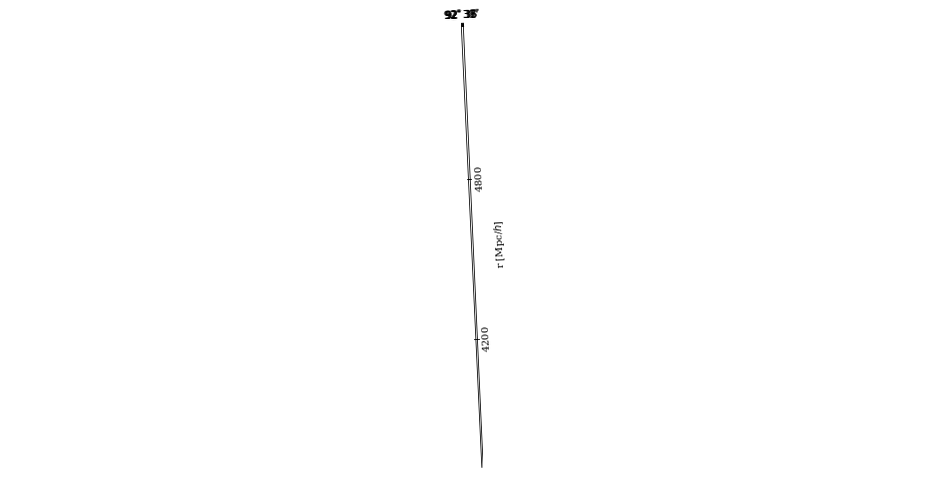

In [61]:
pvfmine(deltas, quasars, ra_range, 0.04, holes, 5,100,5, figure_file=None)